In [36]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import re
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("questions.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404351, 6)

In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
def text_to_word_list(phrase):
    phrase = str(phrase)
    phrase = phrase.lower()
    phrase = re.sub(r"[^A-Za-z]+", " ", phrase)
    phrase = re.sub(r"t", " not", phrase)
    phrase = re.sub(r"re", " are", phrase)
    phrase = re.sub(r"s", " is", phrase)
    phrase = re.sub(r"d", " would", phrase)
    phrase = re.sub(r"ll", " will", phrase)
    phrase = re.sub(r"t", " not", phrase)
    phrase = re.sub(r"ve", " have", phrase)
    phrase = re.sub(r"m", " am", phrase)
    words= phrase.split()
    text=' '.join(str(j) for j in words if j not in stop_words and (len(j)!=1))
    return text

In [8]:
df['question1']=df['question1'].apply(lambda x:text_to_word_list(x))
df['question2']=df['question2'].apply(lambda x:text_to_word_list(x))

In [9]:
t = Tokenizer()
t.fit_on_texts(df['question1'].values+df['question2'].values)

In [10]:
X = df[['question1', 'question2']]
Y = df['is_duplicate']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2)

In [11]:
train1_seq = t.texts_to_sequences(X_train['question1'].values)
test1_seq = t.texts_to_sequences(X_test['question1'].values)

In [12]:
len_vec1 = [len(sent_vec) for sent_vec in train1_seq]

In [13]:
np.max(len_vec1)

103

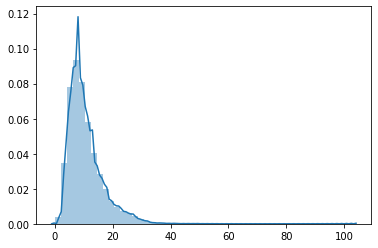

In [14]:
sns.distplot(len_vec1)

In [15]:
train2_seq = t.texts_to_sequences(X_train['question2'].values)
test2_seq = t.texts_to_sequences(X_test['question2'].values)

In [16]:
len_vec2 = [len(sent_vec) for sent_vec in train2_seq]

np.max(len_vec2)

218

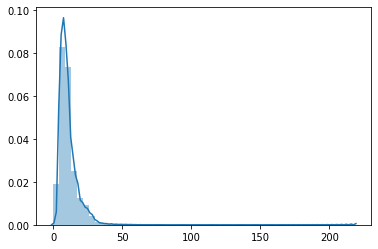

In [17]:
sns.distplot(len_vec2)

In [18]:
max_len=50

In [19]:
train1_seq = pad_sequences(train1_seq, maxlen=max_len, padding='post')
train2_seq = pad_sequences(train2_seq, maxlen=max_len, padding='post')
test1_seq = pad_sequences(test1_seq, maxlen=max_len, padding='post')
test2_seq = pad_sequences(test2_seq, maxlen=max_len, padding='post')

In [20]:
embeddings_index = {}
f = open('glove.6B.300d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
word_index = t.word_index 

print("Words in index: %d" % len(word_index))

Words in index: 126566


In [22]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
embedding_matrix.shape

(126567, 300)

In [24]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [25]:
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 10

left_input = Input(shape=(max_len,), dtype='int32')
right_input = Input(shape=(max_len,), dtype='int32')

embedding_layer = Embedding(len(embedding_matrix), embedding_dim, weights=[embedding_matrix], input_length=max_len,trainable=False)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

shared_lstm = LSTM(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)
 
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
   
malstm = Model([left_input, right_input], [malstm_distance])

optimizer = Adadelta(clipnorm=gradient_clipping_norm)
malstm.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [26]:
malstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      37970100    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           70200       embedding_1[0][0]          

In [27]:
malstm_trained = malstm.fit([train1_seq,train2_seq],Y_train,batch_size=64,epochs=6,verbose=1,validation_split=0.1)

Train on 291130 samples, validate on 32348 samples
Epoch 1/6
291130/291130 [==============================] - 323s 1ms/step - loss: 0.2184 - accuracy: 0.6750 - val_loss: 0.1991 - val_accuracy: 0.7111
Epoch 2/6
291130/291130 [==============================] - 325s 1ms/step - loss: 0.1960 - accuracy: 0.7161 - val_loss: 0.1959 - val_accuracy: 0.7127
Epoch 3/6
291130/291130 [==============================] - 311s 1ms/step - loss: 0.1871 - accuracy: 0.7317 - val_loss: 0.1850 - val_accuracy: 0.7314
Epoch 4/6
291130/291130 [==============================] - 314s 1ms/step - loss: 0.1803 - accuracy: 0.7434 - val_loss: 0.1806 - val_accuracy: 0.7419
Epoch 5/6
291130/291130 [==============================] - 320s 1ms/step - loss: 0.1752 - accuracy: 0.7514 - val_loss: 0.1786 - val_accuracy: 0.7426
Epoch 6/6
291130/291130 [==============================] - 334s 1ms/step - loss: 0.1707 - accuracy: 0.7601 - val_loss: 0.1763 - val_accuracy: 0.7461


In [33]:
predicted=malstm.predict([test1_seq,test2_seq])

In [40]:
def performance_report(actual, predicted):
    scores = []
    for score in predicted:
        if score >= 0.5:
            scores.append(1)
        else:
            scores.append(0)
    accuracy = accuracy_score(actual, scores) * 100
    print("Accuracy score is {}%.".format(round(accuracy),1))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(actual, scores))
    print()
    print("Classification Report:")
    print(classification_report(actual, scores))

In [41]:
performance_report(Y_test,predicted)

Accuracy score is 75.0%.

Confusion Matrix:
[[42974  8161]
 [12147 17588]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     51135
           1       0.68      0.59      0.63     29735

    accuracy                           0.75     80870
   macro avg       0.73      0.72      0.72     80870
weighted avg       0.74      0.75      0.74     80870

